###### Università degli Studi di Milano, Data Science and Economics Master Degree

# RL Tabular Agents

### Alfio Ferrara

A Reinforcement Learning (RL) _tabular agent_ is a type of RL model that uses tabular methods to represent and update the value functions associated with state and state-action pairs. This approach relies on explicitly maintaining a table where each entry corresponds to a specific state or state-action pair. Tabular agents are typically used in environments with discrete and relatively small state and action spaces, enabling direct lookup and updates without the need for function approximation. These agents learn optimal policies by iteratively updating the table based on rewards and transitions experienced through interaction with the environment.

## Agent anatomy
The key components of an Agent are:
- $V(s)$ or $Q(s, a)$: this are discrete representations of the value associated by the agent to each state or state-action pair, depending on the approach
- $s$: the Agent current state during its interaction with the Environment
- $\pi(s)$: the Agent policy, used to select the action based on the current status and the functions $V(s)$ or $Q(s, a)$

The key methods that an Agent needs are:
- `update`: to update the value of states and state-action pairs
- `train`: to perform several interaction cycles with the Enviroment (possibly through multiple episodes) in order to explore the action space 
- `explore`: this method defines how to exploit the actual policy. An example of such a strategy is the _greedy_ strategy, where the Agent exploits its policy in every interation, trying to perform always what looks like the best choice of action. A popular strategy is called $\epsilon$-greedy, where the Agents goes greedy with probability $\epsilon$ and explores with a random action with probability $1 - \epsilon$. This is typically used to address the exploitation-exploration dilemma.

## Example: FrozenLake

In order to implement Agents exploiting several algorithms for learning, we use the `gym.ForzenLake` environment. See [Gym Introduction](./L0.0-gym-introduction.ipynb) for an introduction on the environment.

In [20]:
import gymnasium as gym

In [21]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

## Generic Agent development notes

For a generaric tabular Agent see [TabularAgent class](./agents/tabular.py).

As for the `explore` method, we use $\epsilon$-greedy strategy with epsilon decay:

$$
\pi(s, t) = \left\{\begin{array}{cl} \pi(s, t - 1) & \textrm{with probability}\ \epsilon \\ \textrm{random sample} & \textrm{with probability}\ 1 - \epsilon \\  \end{array} \right.
$$

## Training QLearning Agent

In [22]:
from agents.tabular import QLearning, Sarsa

In [43]:
episodes = 30_000
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=episodes)

In [44]:
q_learn = QLearning(env=env, gamma=0.9, final_epsilon=0)
q_learn.train(max_iterations=episodes, save_every=1_000)

100%|██████████| 30000/30000 [00:05<00:00, 5146.28it/s] 


#### Statistics

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [46]:
def conv(a, win=1000):
    return np.convolve(a, np.ones(win), mode='same') / win

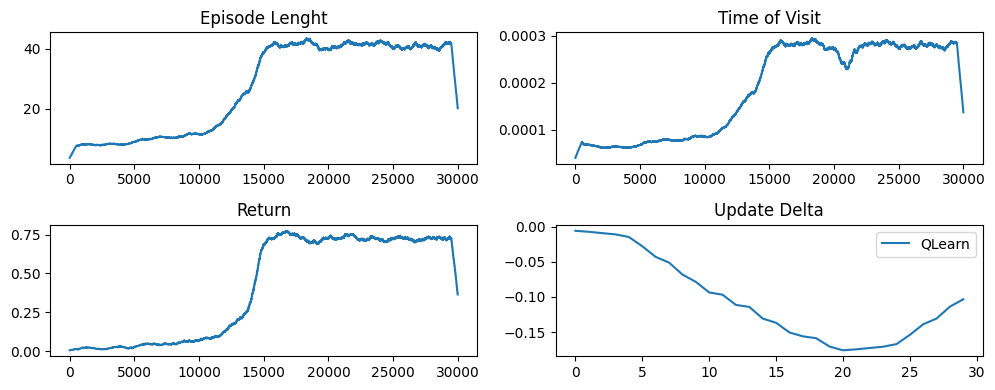

In [47]:
fig, ax = plt.subplots(figsize=(10, 4), ncols=2, nrows=2)
sns.lineplot(x=range(episodes), y=conv(env.length_queue), ax=ax[0,0])
sns.lineplot(x=range(episodes), y=conv(env.time_queue), ax=ax[0,1])
sns.lineplot(x=range(episodes), y=conv(env.return_queue), ax=ax[1,0])
sns.lineplot(x=range(len(q_learn.error)), y=conv(q_learn.error, 20), ax=ax[1,1], label="QLearn")
ax[0,0].set_title("Episode Lenght")
ax[0,1].set_title("Time of Visit")
ax[1,0].set_title("Return")
ax[1,1].set_title("Update Delta")
plt.tight_layout()
plt.show()

### Agent in action

In [48]:
import time
from IPython.display import clear_output

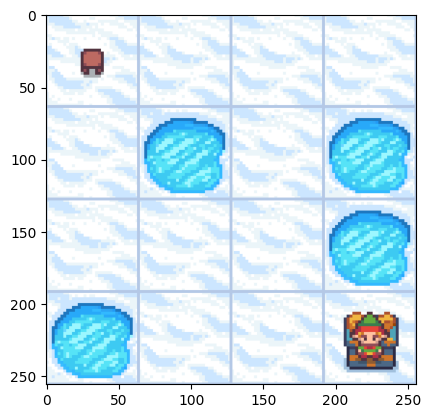

In [49]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array')
state, info = env.reset()

def policy(state: int):
    action = q_learn.greedy(state)
    return action

end_episode = False 
while not end_episode:
    action = policy(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    time.sleep(.1)
    state = s_prime
    
env.close()

## Training SARSA Agent

With SARSA, we exploit the greedy policy to get $(s, a, r, s', a')$ in order to compute

$$
\hat{Q}(s, a) = r + \gamma Q(s', a')
$$

In [50]:
episodes = 30_000
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=episodes)

sarsa = Sarsa(env=env, gamma=0.9, final_epsilon=0)
sarsa.train(max_iterations=episodes, save_every=1_000)

100%|██████████| 30000/30000 [00:05<00:00, 5000.66it/s] 


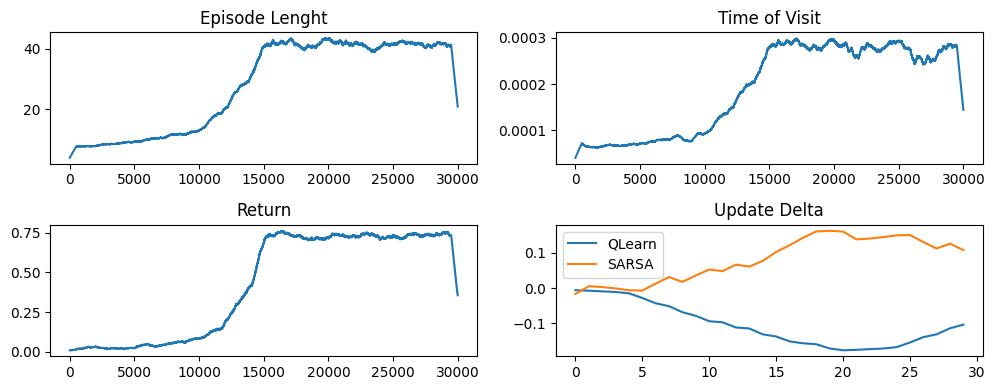

In [51]:
fig, ax = plt.subplots(figsize=(10, 4), ncols=2, nrows=2)
sns.lineplot(x=range(episodes), y=conv(env.length_queue), ax=ax[0,0])
sns.lineplot(x=range(episodes), y=conv(env.time_queue), ax=ax[0,1])
sns.lineplot(x=range(episodes), y=conv(env.return_queue), ax=ax[1,0])
sns.lineplot(x=range(len(q_learn.error)), y=conv(q_learn.error, 20), ax=ax[1,1], label='QLearn')
sns.lineplot(x=range(len(sarsa.error)), y=conv(sarsa.error, 20), ax=ax[1,1], label="SARSA")
ax[0,0].set_title("Episode Lenght")
ax[0,1].set_title("Time of Visit")
ax[1,0].set_title("Return")
ax[1,1].set_title("Update Delta")
plt.tight_layout()
plt.show()

## Training a MonteCarlo Agent

Monte Carlo methods are ways of solving the reinforcement learning problem based on averaging sample returns. To ensure that well-defined returns are available, here we define Monte Carlo methods only for episodic tasks. That is, we assume experience is divided into episodes, and that all episodes eventually terminate no matter what actions are selected. Only on the completion of an episode are value estimates and policies changed.

> Sutton, Richard S.; Barto, Andrew G.. Reinforcement Learning, second edition: An Introduction (Adaptive Computation and Machine Learning series) (English Edition) (p. 91).

So, as a first thing we need a new method to generate an episode following the actual policy $\pi \rightarrow s_0, a_0, r_1, s_1, a_1, r_2, s_2, \dots$

In [52]:
from agents.tabular import MonteCarlo

In [53]:
episodes = 30_000
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=episodes)

montecarlo = MonteCarlo(env=env, gamma=0.9, final_epsilon=0)
episode = montecarlo.generate_episode()
print(episode)

[(0, 1, 0.0), (4, 2, 0.0), (0, 3, 0.0), (1, 3, 0.0), (1, 3, 0.0), (0, 0, 0.0), (0, 1, 0.0), (0, 0, 0.0), (0, 3, 0.0), (0, 3, 0.0), (0, 0, 0.0), (0, 3, 0.0), (0, 1, 0.0), (0, 0, 0.0), (0, 1, 0.0), (0, 3, 0.0), (0, 3, 0.0), (0, 3, 0.0), (0, 1, 0.0), (0, 0, 0.0), (4, 2, 0.0), (0, 2, 0.0), (0, 3, 0.0), (0, 0, 0.0), (0, 2, 0.0), (1, 1, 0.0), (2, 2, 0.0), (2, 3, 0.0), (1, 0, 0.0), (1, 0, 0.0), (1, 3, 0.0), (1, 0, 0.0), (5, 1, 0.0)]


The training process is then performed by a loop on several episodes.

For each episode we first compute the return $G_t$ at time $t$, which is the discounted comulative reward from time $t$

$$
G_t = \sum\limits_{i=0}^{T-t-1} \gamma^{i} r_{t+i+1}
$$

To compute this quantity, for each state-action pair $(s_t, a_t)$, we identify its first occurrence and compute $G_t$ from the time $t$ of this first occurrence on (this is known as MonteCarlo _first visit_). As an alternative is also possible to compute the return for all the occurrences.

**Update**

For each state-value pairs $(s, a)$, we keep a list of all the returns. The $Q(s, a)$ function is then updated as the average of those returns:

$$
Q(s, a) = \frac{1}{N(s, a)} \sum\limits_{i=0}^{N(s, a)} G_i(s, a)
$$

In [55]:
episodes = 30_000
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=episodes)

montecarlo = MonteCarlo(env=env, gamma=0.9, final_epsilon=0)
montecarlo.train(max_iterations=episodes, save_every=1_000)

100%|██████████| 30000/30000 [00:02<00:00, 14174.77it/s]


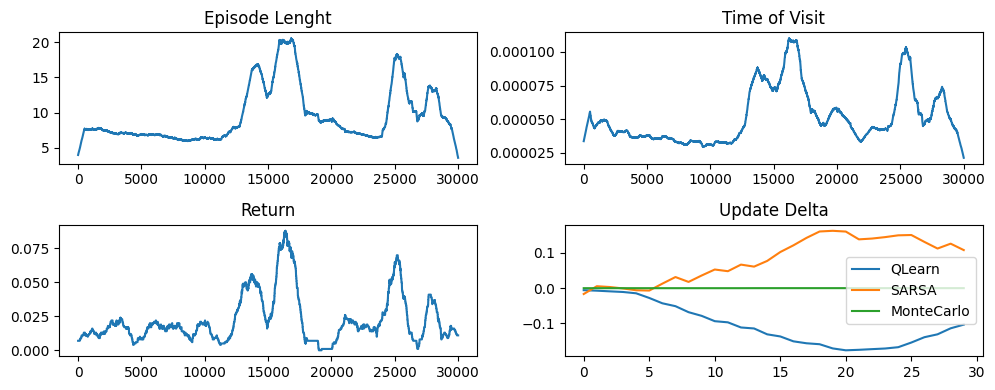

In [56]:
fig, ax = plt.subplots(figsize=(10, 4), ncols=2, nrows=2)
sns.lineplot(x=range(episodes), y=conv(env.length_queue), ax=ax[0,0])
sns.lineplot(x=range(episodes), y=conv(env.time_queue), ax=ax[0,1])
sns.lineplot(x=range(episodes), y=conv(env.return_queue), ax=ax[1,0])
sns.lineplot(x=range(len(q_learn.error)), y=conv(q_learn.error, 20), ax=ax[1,1], label='QLearn')
sns.lineplot(x=range(len(sarsa.error)), y=conv(sarsa.error, 20), ax=ax[1,1], label="SARSA")
sns.lineplot(x=range(len(montecarlo.error)), y=conv(montecarlo.error, 20), ax=ax[1,1], label="MonteCarlo")
ax[0,0].set_title("Episode Lenght")
ax[0,1].set_title("Time of Visit")
ax[1,0].set_title("Return")
ax[1,1].set_title("Update Delta")
plt.tight_layout()
plt.show()

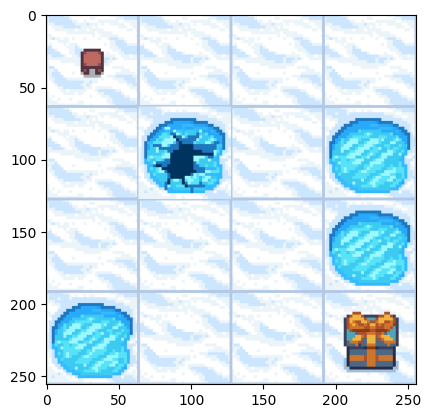

In [58]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array')
state, info = env.reset()

def policy(state: int):
    action = montecarlo.greedy(state)
    return action

end_episode = False 
while not end_episode:
    action = policy(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    time.sleep(.1)
    state = s_prime
    
env.close()